In [34]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import datetime
import inception
import math
import scipy
import scipy.misc

In [35]:
# Helper functions to load and format CIFAR-10 images

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_image(file):
    dict = unpickle(file)
    x = dict[b'data']
    con = x/np.float32(255)
    s = np.dstack((con[:, :1024], con[:, 1024:2048], con[:, 2048:]))
    result = s.reshape((s.shape[0], 32, 32, 3)).transpose(0,1,2,3)
    return result

#img = load_image('cifar-100-python/train')
#img = load_image('image_32')
img = load_image('cifar-10-batches-py/data_batch_1')

#scipy.misc.imread('image_32').astype(np.float)

In [36]:
inception.data_dir = 'inception/'

# TODO: retrain inception
inception.maybe_download()
model = inception.Inception()
resized_image = model.resized_image
y_pred = model.y_pred
y_logits = model.y_logits

# Set the graph for the Inception model as the default graph,
# so that all changes inside this with-block are done to that graph.
with model.graph.as_default():
    # Add a placeholder variable for the target class-number.
    # This will be set to e.g. 300 for the 'bookcase' class.
    pl_cls_target = tf.placeholder(dtype=tf.int32)

    # Add a new loss-function. This is the cross-entropy.
    # See Tutorial #01 for an explanation of cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_logits, labels=[pl_cls_target])

    # Get the gradient for the loss-function with regard to
    # the resized input image.
    gradient = tf.gradients(loss, resized_image)

session = tf.Session(graph=model.graph)
time = datetime.datetime.now().strftime('%m%d%H%M%S')
os.mkdir(time)
log_file = open(time + '/log.txt','w') 
result_file = open(time + '/result.txt','w') 

image_dir = 'images/'
image = 'test_1063.JPEG'
image_path = image_dir + image
feed_dict = model._create_feed_dict(image_path=image_path)

#image = img[100]
#image_path= 'cifar/'
#feed_dict = model._create_feed_dict(image=image)

cls_target=300
noise_limit=3.0
required_score=0.99
log_file=log_file
result_file=result_file
time=time
show_image=False


pred, image = session.run([y_pred, resized_image],
                              feed_dict=feed_dict)

Data has apparently already been downloaded and unpacked.


In [37]:
def normalize_image(x):
    # Get the min and max values for all pixels in the input.
    x_min = x.min()
    x_max = x.max()

    # Normalize so all values are between 0.0 and 1.0
    x_norm = (x - x_min) / (x_max - x_min)

    return x_norm

(1, 299, 299, 3)


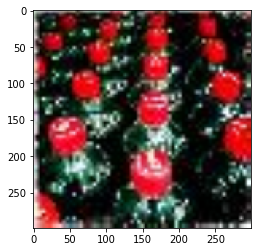

In [38]:
image
print(image.shape)
plt.imshow(normalize_image(image[0]))
#plt.imshow(img[0])
plt.show()    

In [39]:
def find_nearest_cluster(current_pixel, k_means):
	diff_sq = np.square(k_means - np.tile(current_pixel,(16,1)))
	sum_of_sq = diff_sq[:,0] + diff_sq[:,1] + diff_sq[:,2]
	return np.argmin(sum_of_sq)

In [40]:
def compress(image):
    compressed_image = image
    for i in range(compressed_image.shape[0]):
        for j in range(compressed_image.shape[1]):
            for k in range(compressed_image.shape[2]):
                compressed_image[i,j,k] -= compressed_image[i,j,k]%64
    return compressed_image

In [41]:
cls_source = np.argmax(pred)
cls_target = 300

# Score for the predicted class (aka. probability or confidence).
score_source_org = pred.max()

# Names for the source and target classes.
name_source = model.name_lookup.cls_to_name(cls_source,
                                            only_first_name=True)
print(name_source)

prayer rug


In [ ]:
def test_precision(i, image):
    test_image = np.clip(a=image, a_min=0.0, a_max=255.0)

    # Create a feed-dict. This feeds the noisy image to the
    # tensor in the graph that holds the resized image, because
    # this is the final stage for inputting raw image data.
    # This also feeds the target class-number that we desire.
    feed_dict = {model.tensor_name_resized_image: [test_image],
                 pl_cls_target: cls_target}

    # Calculate the predicted class-scores as well as the gradient.
    pred, grad = session.run([y_pred, gradient],
                             feed_dict=feed_dict)

    '''
    final_class = np.argmax(pred)

    # Names for the source and target classes.
    name_source = model.name_lookup.cls_to_name(final_class,
                                                only_first_name=True)
    print('is classified as {} with score {}'. format(name_source, pred.max()))
    '''
    
    # Convert the predicted class-scores to a one-dim array.
    pred = np.squeeze(pred)

    # The scores (probabilities) for the source and target classes.
    score_source = pred[cls_source]
    score_target = pred[cls_target]

    print('interation {}'.format(i))
    
    print('source score is {}'.format(score_source))
    print('target score is {}'.format(score_target))

In [ ]:
cls_source = np.argmax(pred)
cls_target = 300

# Score for the predicted class (aka. probability or confidence).
score_source_org = pred.max()

# Names for the source and target classes.
name_source = model.name_lookup.cls_to_name(cls_source,
                                            only_first_name=True)
name_target = model.name_lookup.cls_to_name(cls_target,
                                            only_first_name=True)

log_file.write(image_path + "\n\n")
# Initialize the noise to zero.
noise = 0
iterations = 0
# Perform a number of optimization iterations to find
# the noise that causes mis-classification of the input image.
for i in range(10000):
    iterations = i
    log_file.write("Iteration:" + str(i) + "\n")

    # The noisy image is just the sum of the input image and noise.
    noisy_image = image + noise

    # Ensure the pixel-values of the noisy image are between
    # 0 and 255 like a real image. If we allowed pixel-values
    # outside this range then maybe the mis-classification would
    # be due to this 'illegal' input breaking the Inception model.
    noisy_image = np.clip(a=noisy_image, a_min=0.0, a_max=255.0)

    # Create a feed-dict. This feeds the noisy image to the
    # tensor in the graph that holds the resized image, because
    # this is the final stage for inputting raw image data.
    # This also feeds the target class-number that we desire.
    feed_dict = {model.tensor_name_resized_image: noisy_image,
                 pl_cls_target: cls_target}

    # Calculate the predicted class-scores as well as the gradient.
    pred, grad = session.run([y_pred, gradient],
                             feed_dict=feed_dict)

    # Convert the predicted class-scores to a one-dim array.
    pred = np.squeeze(pred)

    # The scores (probabilities) for the source and target classes.
    score_source = pred[cls_source]
    score_target = pred[cls_target]

    # Squeeze the dimensionality for the gradient-array.
    grad = np.array(grad).squeeze()

    # The gradient now tells us how much we need to change the
    # noisy input image in order to move the predicted class
    # closer to the desired target-class.
    
    # Calculate the max of the absolute gradient values.
    # This is used to calculate the step-size.
    grad_absmax = np.abs(grad).max()
    
    # If the gradient is very small then use a lower limit,
    # because we will use it as a divisor.
    if grad_absmax < 1e-10:
        grad_absmax = 1e-10

    # Calculate the step-size for updating the image-noise.
    # This ensures that at least one pixel colour is changed by 7.
    # Recall that pixel colours can have 255 different values.
    # This step-size was found to give fast convergence.
    step_size = 0.3 / grad_absmax
   
    
    '''
    l2_disturb = np.linalg.norm(noise)/np.linalg.norm(image)

    step_size = 0.1 / max(0.00001, math.sqrt(l2_disturb))
    '''
    
    '''
    # Print the score etc. for the source-class.
    msg = "Source score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}\n"
    log_file.write(msg.format(score_source, cls_source, name_source))

    # Print the score etc. for the target-class.
    msg = "Target score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}\n"
    log_file.write(msg.format(score_target, cls_target, name_target))

    # Print statistics for the gradient.
    msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}\n\n"
    log_file.write(msg.format(grad.min(), grad.max(), step_size))
    '''
    
    test_precision(iterations, (image + noise)[0])
    test_precision(iterations, compress((image + noise)[0]))

    # If the score for the target-class is not high enough.
    #if score_target < required_score:
    if score_target < required_score:
        # Update the image-noise by subtracting the gradient
        # scaled by the step-size.
        noise -= step_size * grad

        # Ensure the noise is within the desired range.
        # This avoids distorting the image too much.
        noise = np.clip(a=noise,
                        a_min=-noise_limit,
                        a_max=noise_limit)
        print ('l2 norm is {}'.format(math.sqrt(np.linalg.norm(noise)/np.linalg.norm(image))))
                
    else:
        # Abort the optimization because the score is high enough.
        break
        
plt.imshow(normalize_image(image.squeeze()))
plt.show() 

plt.imshow(normalize_image(noisy_image.squeeze()))
plt.show() 

plt.imshow(normalize_image(noise))
plt.show() 

print(iterations)

print(name_source)
print(name_target)

'''
       image.squeeze(), noisy_image.squeeze(), noise, \
       name_source, name_target, \
       score_source, score_source_org, score_target, iterations
'''

interation 0
source score is 0.3805735409259796
target score is 3.609945997595787e-05
interation 0
source score is 0.0803854689002037
target score is 5.306470120558515e-05
l2 norm is 0.01721290068132121
interation 1
source score is 0.26692599058151245
target score is 8.147970220306888e-05
interation 1
source score is 0.06693243235349655
target score is 5.8812413044506684e-05
l2 norm is 0.02362019269912793
interation 2
source score is 0.17235715687274933
target score is 0.0001595354697201401
interation 2
source score is 0.05246385559439659
target score is 6.137512536952272e-05
l2 norm is 0.028263762140844948
interation 3
source score is 0.1383279711008072
target score is 0.0002966511237900704
interation 3
source score is 0.05160563439130783
target score is 6.191453576320782e-05
l2 norm is 0.03190398060793973
interation 4
source score is 0.11920781433582306
target score is 0.0004778438596986234
interation 4
source score is 0.04633214324712753
target score is 6.12110598012805e-05
l2 norm 

interation 40
source score is 0.034969959408044815
target score is 0.6101655960083008
interation 40
source score is 0.07669589668512344
target score is 5.173491081222892e-05
l2 norm is 0.07590326301226534
interation 41
source score is 0.019705938175320625
target score is 0.6455763578414917
interation 41
source score is 0.07289372384548187
target score is 4.7646521124988794e-05
l2 norm is 0.07636041111162177
interation 42
source score is 0.026379253715276718
target score is 0.6799342632293701
interation 42
source score is 0.07243277877569199
target score is 4.879625703324564e-05
l2 norm is 0.07688782833515632
interation 43
source score is 0.016731470823287964
target score is 0.7066203951835632
interation 43
source score is 0.06757725030183792
target score is 4.8960402637021616e-05
l2 norm is 0.07716759009378191
interation 44
source score is 0.018855247646570206
target score is 0.7331868410110474
interation 44
source score is 0.06853833794593811
target score is 4.976170021109283e-05
l2 n

In [230]:
feed_dict = {model.tensor_name_resized_image: image,
                 pl_cls_target: cls_target}

pred, grad = session.run([y_pred, gradient],
                             feed_dict=feed_dict)
pred = np.squeeze(pred)

score_source = pred[cls_source]
score_target = pred[cls_target]

print(score_source)
print(score_target)

0.288837
4.8054e-05


In [231]:
feed_dict = {model.tensor_name_resized_image: noisy_image,
                 pl_cls_target: cls_target}

pred, grad = session.run([y_pred, gradient],
                             feed_dict=feed_dict)
pred = np.squeeze(pred)

score_source = pred[cls_source]
score_target = pred[cls_target]

print(score_source)
print(score_target)

0.142788
0.0108013


In [195]:
score_source_org

0.33490974

In [197]:
noise.shape

(299, 299, 3)

In [201]:
print (l2_disturb)

0.030005215665493506


In [207]:
print (l2_disturb)

0.030005215665493506


In [ ]:
test_precision('final')

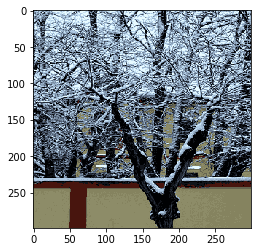

In [100]:
# (b) Calculate 16 means' centroid
A = image[0]
k = 16
# Random initialize each k-mean's centroid from a cell in small picture
index1 = np.random.randint(0,A.shape[0],k)
index2 = np.random.randint(0,A.shape[1],k)
k_means = A[index1, index2, :].astype(float)
for x in range(100):
	new_means = np.zeros((k, A.shape[2])).astype(float)
	new_means_count = np.zeros(k).astype(float)
	for i in range(A.shape[0]):
		for j in range(A.shape[1]):
			nearest_centroid = find_nearest_cluster(A[i,j,:], k_means)
			new_means_count[nearest_centroid] += 1
			new_means[nearest_centroid] += A[i,j,:]
	# Replace the k-means with new centroids
	k_means = np.divide(new_means,np.tile(new_means_count, (3,1)).T)

# (c) Replace large image's all color with the nearest centroid's color
compressed_image = image[0]
for i in range(compressed_image.shape[0]):
	for j in range(compressed_image.shape[1]):
		nearest_centroid = find_nearest_cluster(compressed_image[i,j,:], k_means)
		compressed_image[i,j,:] = k_means[nearest_centroid]
        
plt.imshow(normalize_image(compressed_image))
plt.show()    
#image[0] = compressed_image